In [1]:
import os
import gc
import random

import numpy as np

import rasterio

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor

from torchvision.utils import make_grid

from torchgeo.datasets import (RasterDataset, 
                               stack_samples, 
                               splits, 
                               random_bbox_splitting)

from skimage.util import img_as_ubyte, img_as_float32, img_as_float, img_as_float64
from skimage import io

from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

from torchinfo import summary
from torchmetrics.classification import (MulticlassF1Score, 
                                         MulticlassConfusionMatrix, 
                                         MulticlassJaccardIndex)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, jaccard_score, f1_score

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss, FocalLoss

from einops import rearrange

from pprint import pprint

from tqdm.auto import tqdm, trange

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = 'retina'

In [2]:
%%time

with rasterio.open('./data/18210.tif', dtype=np.float32) as src:
    arr = src.read()
    sar_img_2018 = np.transpose(arr, (1, 2, 0))

with rasterio.open('./data/19229.tif', dtype=np.float32) as src:
    arr = src.read()
    sar_img_2019 = np.transpose(arr, (1, 2, 0))

with rasterio.open('./data/20218.tif', dtype=np.float32) as src:
    arr = src.read()
    sar_img_2020 = np.transpose(arr, (1, 2, 0))


CPU times: user 42.3 s, sys: 6.24 s, total: 48.6 s
Wall time: 1min 8s


In [3]:
sar_img_2018.shape

(10970, 11567, 2)

CPU times: user 24.8 s, sys: 7.84 s, total: 32.6 s
Wall time: 32.2 s


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

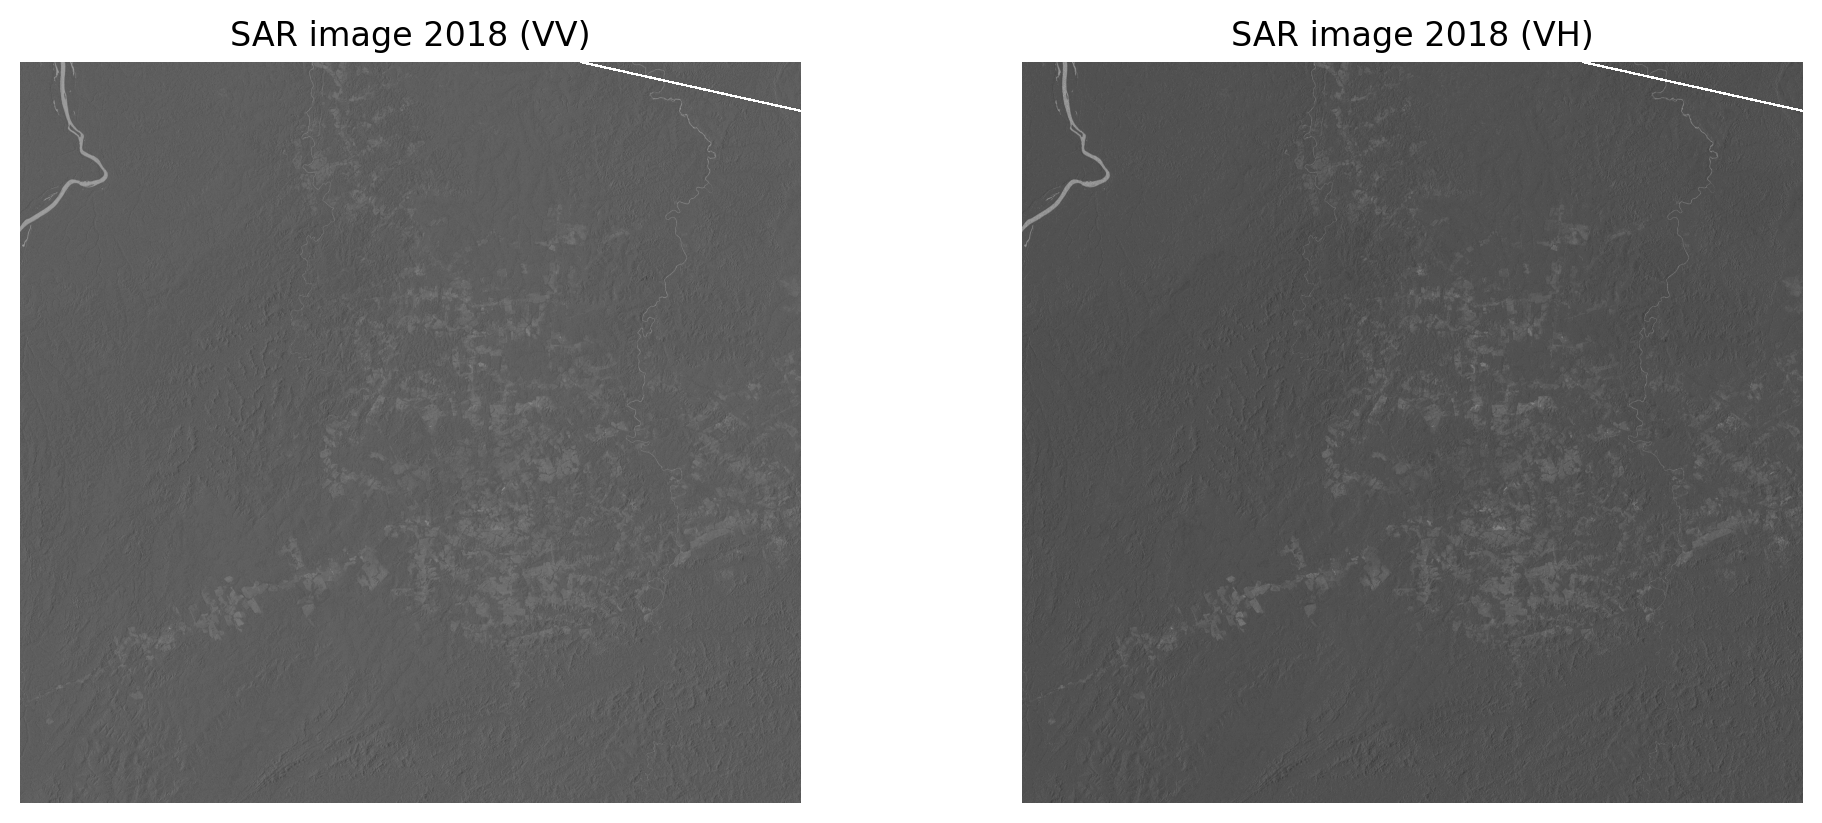

In [4]:
%%time

fig, ax = plt.subplots(1, 2, layout='constrained', figsize=[10, 4])

ax[0].imshow(sar_img_2018[:, :, 0], cmap='gray_r')
ax[0].set_title('SAR image 2018 (VV)')
ax[0].axis('off')

ax[1].imshow(sar_img_2018[:, :, 1], cmap='gray_r')
ax[1].set_title('SAR image 2018 (VH)')
ax[1].axis('off')

plt.savefig(f"./assets/source_images_2018.png", bbox_inches='tight', dpi=300)
plt.tight_layout;